In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.colors import ListedColormap
from skimage import io
import networkx as nx

# general libraries
import os  
import json
import time
import h5py as h5py
import copy
import yaml

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import pack_hdf, unpack_hdf, Workspace
from scalebars import *
import deconv
from hsluv_colormaps import angle_cmap

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse
from line_data_units import LineDataUnits

In [2]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = ""
model_path = os.path.join(base_path, "model_runs")
fig_dir_path = os.path.join(model_path, "figs") 
analysis_path = os.path.join(model_path, "analysis")
exts = [".png", ".svg"]

bmb_green = "#009800ff"
bmb_magenta = "#fe36d0ff"
# hsl for use with angle_cmap (https://htmlcolors.com/hex-to-hsl)
bmb_magenta_hsl = (314, 99, 60)
bmb_green_hsl = (120, 100, 30)

arrow_lbls = ["⬋", "⬇", "⬊", "➡", "⬈", "⬆", "⬉", "⬅"]
arrow_lbls = ["↙", "↓", "↘", "→", "↗", "↑", "↖", "←"]

In [4]:
quanta_h5 = "quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2, # USUAL
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

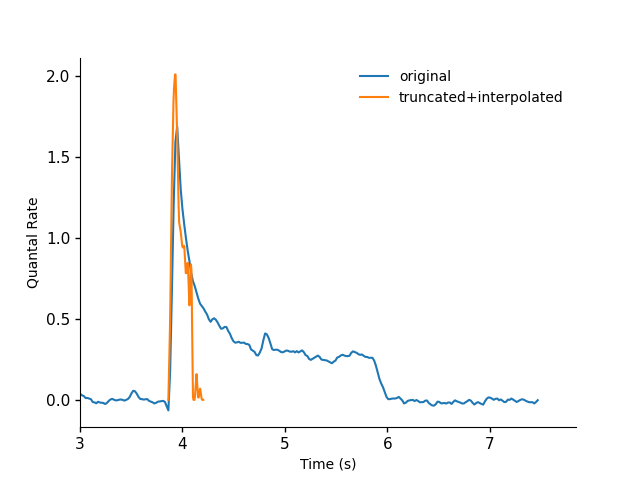

In [5]:
trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="truncated+interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [ ]:
overwrite = False

save_name = "test"
load_name = None

model_config = configs.thesis(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    poisson_rates={"sac": vrate / np.max(vrate), "glut": vrate / np.max(vrate), "dt": target_rate_dt},
    plexus=0,
    plexus_share=None,
    stacked_plex=False,
    record_tree=False, # TURN FALSE FOR RHO RANGE (more than 0 and 1)
)
model_config["downsample"] = {}
model_config["downsample"]["Vm"] = 1.0
model_config["record_tree_g"] = False

save_path = os.path.join(model_path, save_name) + ".h5"
if load_name is None:
    load_name = save_name
    if (not overwrite and os.path.exists(save_path)):
        print(
            "Loading %s rather than overwriting it.\nSet `overwrite = True` if saving over is desired."
            % save_name
        )
    else:
        from ei_balance_nogui import *
        os.makedirs(model_path, exist_ok=True)
        t0 = time.time()
        exps.sacnet_run(
            save_path,
            model_config,
            n_nets=6,
            n_trials=12,
            rho_steps=[0.0, 1.],
            pool_sz=1,
            reset_seed_between_rho=True,
            reset_rng_before_runs=True,
        )
        print("rho run time:", time.time() - t0)

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
with open("directed_dsgc.yaml", mode="r") as fd:
    dsgc_graph = yaml.load(fd, Loader=yaml.Loader)
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(analysis_path, exist_ok=True)

rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())
n_trials, n_dirs, _ = d[rhos[0]][idxs[0]]["soma"]["Vm"][:].shape
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", list(d[rhos[0]][idxs[0]].keys()))

In [7]:
with h5.File("thesis_morphology.h5", "r") as f:
    morph = unpack_hdf(f)

print("morph keys:", list(morph.keys()))

morph keys: ['soma3d', 'soma2d', 'dend_diam', 'dend3d']


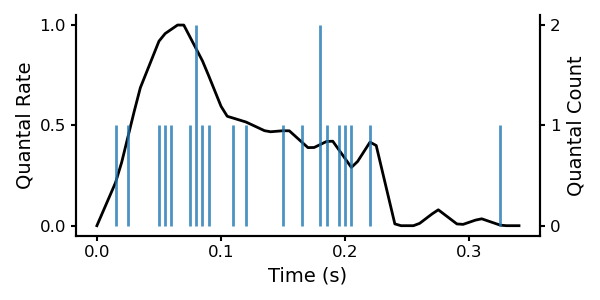

In [8]:
rng = np.random.default_rng()
xaxis = np.arange(len(vrate)) * target_rate_dt

qrate = model_config["sac_rate"]
release_fig, release_ax = plt.subplots(1, figsize=(6, 3))
quanta_ax = release_ax.twinx()
release_ax.plot(xaxis, qrate, lw=2, c="black")
release_ax.set_ylabel("Quantal Rate", fontsize=14)
rpq = deconv.poisson_of_release(rng, qrate)
_, quanta_stems, _ = quanta_ax.stem(
    xaxis,
    rpq,
    linefmt="-",
    markerfmt="none",
    basefmt="none",
)
quanta_stems.set_alpha(0.8)
quanta_stems.set_linewidth(2.)
# quanta_stems.set_color("black")
release_ax.set_yticks([0, 0.5, 1])
quanta_ax.set_yticks(np.arange(rpq.max() + 1))
release_ax.set_xticks([0, 0.1, 0.2, 0.3])
quanta_ax.set_ylabel("Quantal Count", fontsize=14)
release_ax.set_xlabel("Time (s)", fontsize=14)
clean_axes([release_ax, quanta_ax], ticksize=12, spine_width=1.5, remove_spines=["top"])
release_fig.tight_layout()
for ext in [".svg", ".png"]:
    release_fig.savefig(os.path.join(fig_path, "poisson_quanta_ex" + ext), bbox_inches="tight")

In [9]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [10]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
ttx = (d[rhos[0]][idxs[0]]["params"]["soma_Na"] == 0.0
       and d[rhos[0]][idxs[0]]["params"]["prime_Na"] == 0.0
       and d[rhos[0]][idxs[0]]["params"]["dend_Na"] == 0.0)
sac_thetas = ana.get_sac_thetas(d)
sac_deltas = ana.get_sac_deltas(sac_thetas)
tuning_vm = (ana.analyze_tree(d, dir_labels, pref=0, thresh=-56)
             if "dendrites" in d[rhos[0]][idxs[0]].keys() 
             else None)
tuning_cai = (ana.analyze_tree(d, dir_labels, rec_key="cai", pref=0, bin_pts=(300, None), peak=True)
             if "dendrites" in d[rhos[0]][idxs[0]].keys() 
             else None)
tuning = tuning_vm
tuning = tuning_cai

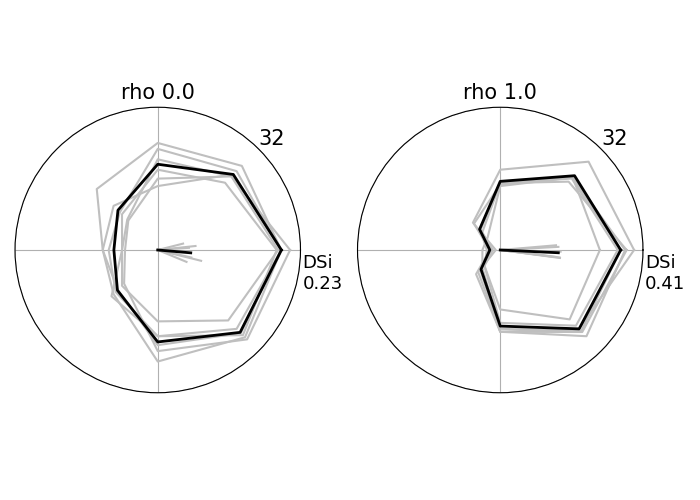

In [11]:
if not ttx:
    show_rhos = list(metrics.keys())
    # show_rhos = [0.0, 1.0]
    # show_rhos = [0.0, 0.9, 0.96, 0.99, 1.0]
    # show_rhos = [0.0, 0.9, 0.96, 1.0]
    # show_rhos = [0.0, 0.4, 0.9, 0.96, 1.0]
    max_spikes = np.max([metrics[r]["spikes"] for r in show_rhos])
    polar_fig = plt.figure(figsize=(7, 5))
    n_cols = len(show_rhos)
    polar_ax = [
        polar_plot(
            metrics[r],
            dir_labels,
            title="rho " + str(r),
            radius=max_spikes,
            net_shadows=True,
            save=False,
            fig=polar_fig,
            sub_loc=(1, n_cols, loc + 1),
            title_metrics=False,
        )
        for loc, r in enumerate(show_rhos)
    ]
    polar_fig.tight_layout()

    rho_lbl = str(show_rhos)[1:-1].replace(", ", "_").replace(".", "p")
    for ext in [".png", ".svg"]:
        polar_fig.savefig(os.path.join(fig_path, "polar_%s%s" % (rho_lbl, ext)), bbox_inches="tight")

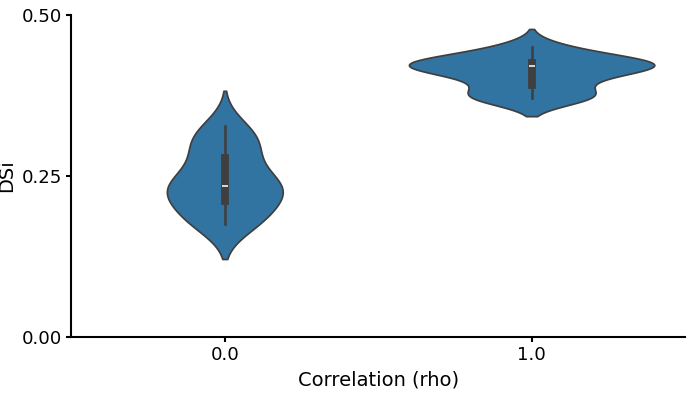

In [12]:
if not ttx:
    show_rhos = list(metrics.keys())
    # show_rhos = [0.0, 1.0]
    show_spks = [135, 180, 225]
    show_spks = []
    show_metrics = {r: metrics[r] for r in show_rhos}
    rho_violin_fig, rho_violin_ax = sac_rho_violins(
        show_metrics,
        dir_labels,
        show_spks=show_spks,
        share_ymax=True,
        figsize=(5, 8) if len(show_spks) == 3 else None if len(show_spks) else (7, 4)
    )
    rho_violin_ax[0].set_yticks([0, 0.25, 0.5])
    clean_axes(rho_violin_ax, spine_width=1.5, ticksize=13)

    for ext in [".png", ".svg"]:
        spk_lbl = ("_spks_" + "_".join(show_spks)) if len(show_spks) else ""
        rho_violin_fig.savefig(os.path.join(fig_path, "violins" + spk_lbl + ext), bbox_inches="tight")

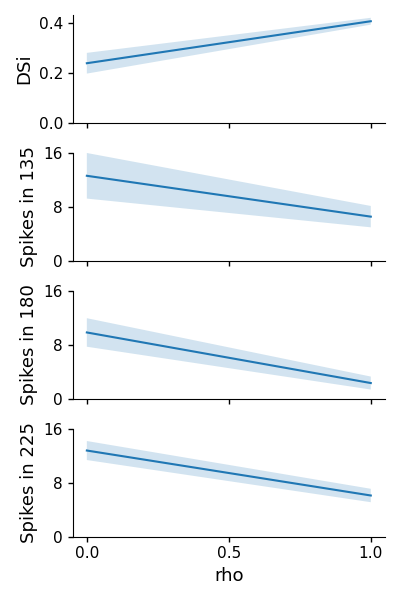

In [13]:
if not ttx:
    share_spk_ymax = True

    rho_dsis = np.stack([metrics[r]["DSis"] for r in rhos], axis=0)
    rho_dsis_flat = rho_dsis.reshape(len(rhos), -1)
    rho_net_avg_dsis = np.mean(rho_dsis, axis=2)
    rho_net_std_dsis = np.std(rho_net_avg_dsis, axis=1)
    rho_spks = np.stack([metrics[r]["spikes"].transpose(2, 0, 1) for r in rhos], axis=0)
    rho_net_avg_spks = np.mean(rho_spks, axis=3)
    rho_net_std_spks = np.std(rho_net_avg_spks, axis=2)
    rho_avg_dsis = np.array([np.mean(metrics[r]["avg_DSi"]) for r in rhos])
    rho_avg_spks = np.stack([np.mean(metrics[r]["spikes"], axis=(0, 1)) for r in rhos], axis=0)
    spk_ylim = np.max(rho_avg_spks[:, [6, 7, 0]] + rho_net_std_spks[:, [6, 7, 0]])
    spk_maxtick = np.round(spk_ylim) if np.round(spk_ylim) % 2 == 0 else np.round(spk_ylim) + 1 
    spk_yticks = [0, spk_maxtick // 2, spk_maxtick]

    def rho_plot_dir(row, dir_idx):
        rho_range_ax[row].fill_between(
            rhos,
            rho_avg_spks[:, dir_idx] + rho_net_std_spks[:, dir_idx],
            rho_avg_spks[:, dir_idx] - rho_net_std_spks[:, dir_idx],
            alpha=0.2,
        )
        rho_range_ax[row].plot(rhos, rho_avg_spks[:, dir_idx])
        rho_range_ax[row].set_ylabel("Spikes in %i" % dir_labels[dir_idx], fontsize=13)
        if share_spk_ymax:
            rho_range_ax[row].set_ylim(0, spk_ylim)
            rho_range_ax[row].set_yticks(spk_yticks)

    rho_range_fig, rho_range_ax = plt.subplots(4, sharex=True, figsize=(4, 6))
    rho_range_ax[0].fill_between(
        rhos,
        rho_avg_dsis + rho_net_std_dsis,
        rho_avg_dsis - rho_net_std_dsis,
        alpha=0.2,
    )
    rho_range_ax[0].plot(rhos, rho_avg_dsis)
    rho_plot_dir(1, 6) # 135
    rho_plot_dir(2, 7) # 180
    rho_plot_dir(3, 0) # 225
    rho_range_ax[0].set_ylabel("DSi", fontsize=13)
    rho_range_ax[-1].set_xlabel("rho", fontsize=13)
    rho_range_ax[-1].set_xticks([0, 0.5, 1.])
    rho_range_ax[0].set_yticks([0, 0.2, 0.4])
    clean_axes(rho_range_ax)
    rho_range_fig.tight_layout()

    for ext in [".png", ".svg"]:
        rho_range_fig.savefig(os.path.join(fig_path, "rho_range" + ext), bbox_inches="tight")

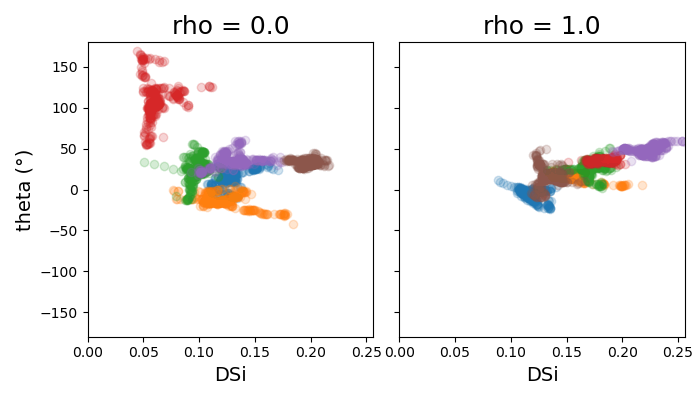

In [14]:
show_rhos = list(metrics.keys())
show_rhos = [0.0, 1.0]
if tuning is not None:
    clrs = ["C%i" % i for i in range(9)]
    show_tuning = {r: tuning[r] for r in show_rhos}
    scatter_fig = ds_scatter(show_tuning, avg=True, palette=clrs, figsize=(7, 4))
    scatter_fig.tight_layout()

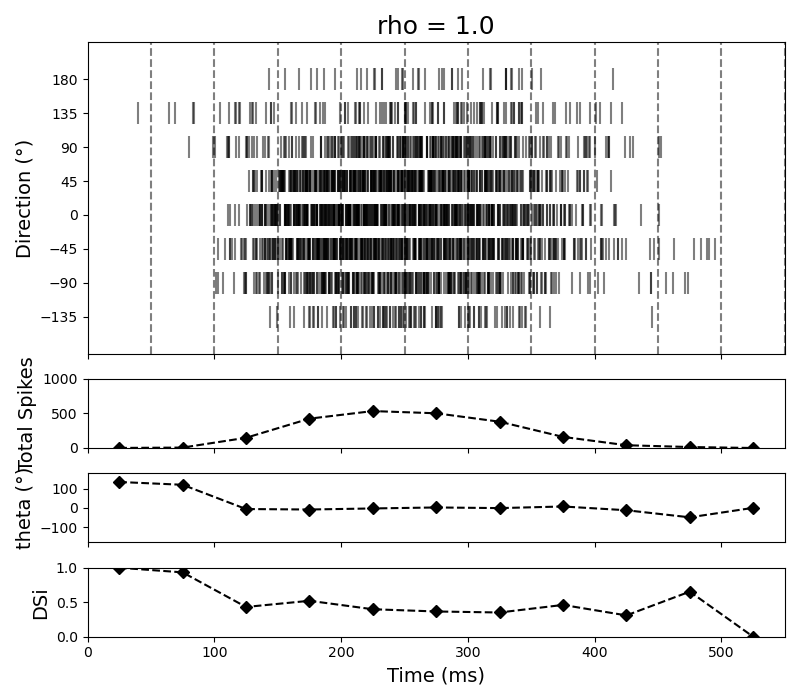

In [15]:
if not ttx:
    # v1000 SR alignment offsets (ms): [54.4 43.  12.6  0.  15.4 42.8 52.3 43.3]
    dir_field_offsets = [10.9, 25.7, 36.4, 22.5, 6.6, 5.6, 1.1, 0.]  # ms

    rho = 1. 
    rasters_fig, _ = spike_rasters(
        d,
        dir_labels,
        rho=rho,
        bin_ms=50,
        offsets=dir_field_offsets,
        colour="black",
        spike_vmax=1000,
        figsize=(8, 7),
    )
    name = os.path.join(fig_path, "rasters_%s" % ("%.2f" % rho).replace(".", "p"))
    for ext in [".png", ".svg"]:
        rasters_fig.savefig(name + ext, bbox_inches="tight")

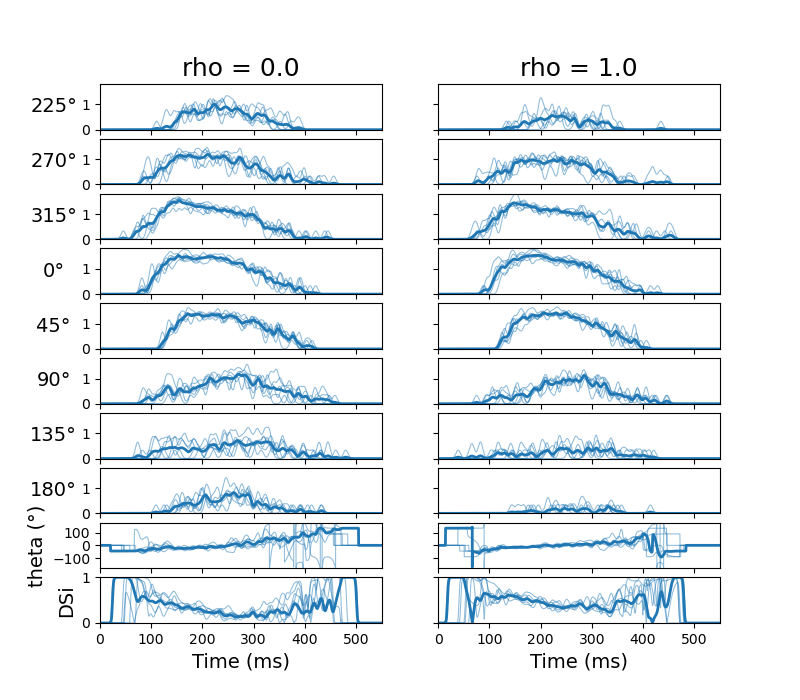

In [16]:
if not ttx:
    evol = time_evolution(d, dir_labels, rhos=[0.0, 1.0], kernel_var=45, figsize=(8, 7))
    evol.savefig(os.path.join(fig_path, "evolution.png"), bbox_inches="tight")
    evol.savefig(os.path.join(fig_path, "evolution.svg"), bbox_inches="tight")

In [17]:
rho = 0.0
if tuning is not None:  # TTX condition
    rec_locs = d[rho][0]["dendrites"]["locs"]
    syn_locs = d[rho][0]["syn_locs"]
    syn_rec_lookups = get_syn_rec_lookups(rec_locs, syn_locs)
    post_syn_avg_tuning = get_postsyn_avg_tuning(tuning, syn_rec_lookups)
    if d[rho][0]["params"]["soma_Na"] == 0.0:   # TTX condition
        theta_diffs = plot_theta_diff_tuning_scatters(post_syn_avg_tuning, sac_deltas, rhos=[rho])
        theta_diff_bins = plot_theta_diff_vs_abs_theta(post_syn_avg_tuning, sac_deltas, rhos=[rho])

In [18]:
sac_thetas[0.0]["E"].shape

(6, 341)

In [19]:
if tuning is not None and d[rho][0]["params"]["soma_Na"] == 0.0:  # TTX condition
    rho = 0.0
    display_sacs = ["E", "I"]
    alpha = 0.2

    sac_vs_tuning_fig, sac_vs_tuning_ax = plt.subplots(
        3, len(display_sacs), sharex="col", sharey="row", figsize=(4 * len(display_sacs), 6))

    if len(display_sacs) > 1:
        # unzip axes from rows in to column-major organization
        sac_vs_tuning_ax = [[a[i] for a in sac_vs_tuning_ax] for i in range(len(rhos))]
    else:
        sac_vs_tuning_ax = [sac_vs_tuning_ax]

    flat_dsis = post_syn_avg_tuning[rho]["DSi"].reshape(-1)
    flat_thetas = post_syn_avg_tuning[rho]["theta"].reshape(-1)
    flat_thetas_abs = np.abs(flat_thetas)

    for k, col in zip(display_sacs, sac_vs_tuning_ax):
        flat_sacs = sac_thetas[rho][k].reshape(-1)
        col[0].scatter(flat_sacs, flat_thetas, alpha=alpha)
        col[1].scatter(flat_sacs, flat_thetas_abs, alpha=alpha)
        col[2].scatter(flat_sacs, flat_dsis, alpha=alpha)
        # SAC Delta vs DSi and absolute theta fits
        not_nan_idxs = ~np.isnan(flat_sacs)
        nanless_sacs = flat_sacs[not_nan_idxs]
        nanless_dsis = flat_dsis[not_nan_idxs]
        nanless_thetas = flat_thetas_abs[not_nan_idxs]
        xaxis = np.linspace(0, np.max(nanless_sacs), 100)
        m, x, r_val, p_val, std_err = linregress(nanless_sacs, nanless_dsis)
        dsi_fit_line = x + m * xaxis
        m, x, r_val, p_val, std_err = linregress(nanless_sacs, nanless_thetas)
        theta_fit_line = x + m * xaxis
        col[1].plot(xaxis, theta_fit_line, c="red")
        col[2].plot(xaxis, dsi_fit_line, c="red")

        # shared X settings
        col[2].set_xlabel("%s Angle (°)" % ("ACh" if k == "E" else "GABA"))
        col[2].set_xlim(0, 360)

    # shared Y settings
    sac_vs_tuning_ax[0][0].set_ylabel("theta (°)", size=14)
    sac_vs_tuning_ax[0][0].set_ylim(-180, 180)
    sac_vs_tuning_ax[0][1].set_ylabel("absolute theta (°)", size=14)
    sac_vs_tuning_ax[0][1].set_ylim(0, 180)
    sac_vs_tuning_ax[0][2].set_ylabel("DSI", size=14)
    sac_vs_tuning_ax[0][2].set_ylim(0, 1)
    sac_vs_tuning_fig.set_layout_engine("compressed")

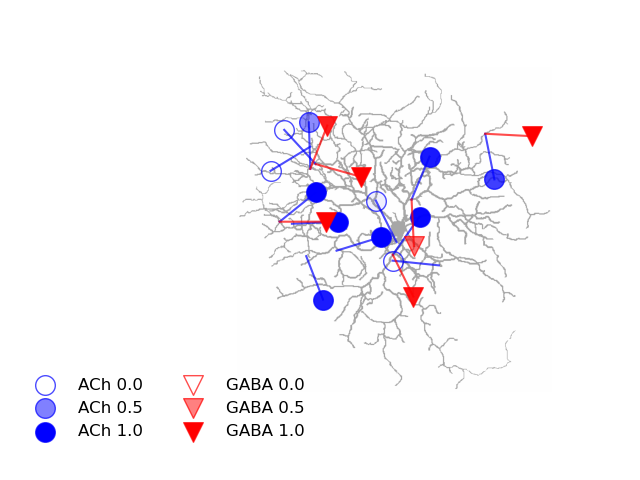

In [20]:
rho = 0.
net = 0
stim_angle = 180
n_syn = 12
seed = 402
show_plex = True
csteps = 512
clr = "black"

gamma = 0.01
min_size = None
c_clear = mpl.colors.colorConverter.to_rgba("white", alpha = 0)
c_black = mpl.colors.colorConverter.to_rgba("black", alpha = 1)
c_red = mpl.colors.colorConverter.to_rgba("red", alpha = 1)
c_blue = mpl.colors.colorConverter.to_rgba("blue", alpha = 1)
cmap = mpl.colors.LinearSegmentedColormap.from_list("rb_cmap", [c_clear, c_black], csteps, gamma=gamma)
ach_cmap = mpl.colors.LinearSegmentedColormap.from_list("rb_cmap", [c_clear, c_blue], csteps, gamma=gamma)
gaba_cmap = mpl.colors.LinearSegmentedColormap.from_list("rb_cmap", [c_clear, c_red], csteps, gamma=gamma)
    
over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    d[rho][net]["syn_locs"],
    d[rho][net]["sac_net"]["wiring"]["bp_locs"],
    d[rho][net]["sac_net"]["wiring"]["probs"],
    dir_labels,
    stim_angle=stim_angle,
    n_syn=n_syn,
    # sac_alpha=None,
    # sac_thickness=2,
    sac_thickness=1.5,
    sac_marker_size=200,
    sac_min_marker_size=min_size,
    syn_choice_seed=seed,
    show_plex=show_plex,
    # ach_color="green",
    # gaba_color="cyan",
    ach_color="blue",
    gaba_color="red",
    # ach_edge="black",
    # gaba_edge="black",
    ach_edge="blue",
    gaba_edge="red",
    cmap=cmap,
    ach_cmap = ach_cmap,
    gaba_cmap = gaba_cmap,
    cbar_orientation="vertical",
    incl_cbars=False,
)
over_fig.set_layout_engine("tight")

if 1:
    size_lbl = "_sized" if min_size is not None else ""
    for ext in [".png", ".svg"]:
        name = "sac_net_rho%s_net%i_dir%i_n%i_seed%i_gamma%.2f%s%s%s" % (
            str(rho).replace(".", "p"),
            net,
            stim_angle,
            n_syn,
            seed,
            gamma,
            size_lbl,
            "_plex" if show_plex and "PLEX" in d[rho][net]["sac_net"]["wiring"]["bp_locs"] else "",
            ext
        )
        over_fig.savefig(os.path.join(fig_path, name))

Average GABA synapse count: 172.24


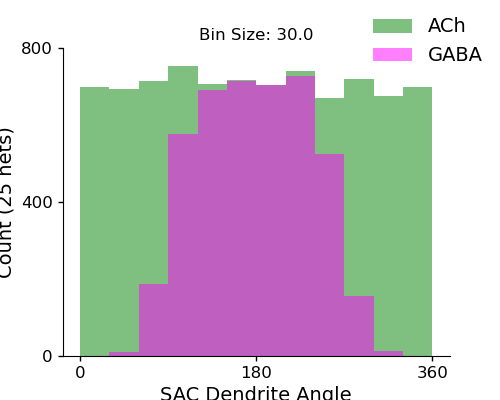

In [21]:
conf = copy.deepcopy(model_config)
conf["seed"] = 4
hist_nets = 25

angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    conf, n_nets=hist_nets, bins=[12], incl_yticks=True, figsize=(5, 4))

for ax in angle_dist_ax:
    ax.set_xticks([0, 180, 360])
    ax.patch.set_alpha(0)

ymin, ymax = ax.get_ybound()
n = n_digits(ymax)
i = 10 ** (n - 1)
if ymax % i != 0:
    ymax = i * (ymax // i + 1)

max_tick = ymax if ymax % 2 == 0 else ymax + 1
ax.set_ylim(0, ymax)
ax.set_yticks([0, max_tick // 2, max_tick])

name = os.path.join(fig_path, "angle_hist_seed%i_%inets" % (conf["seed"], hist_nets))
for ext in [".png", ".svg"]:
    angle_dist_fig.savefig(name + ext, bbox_inches="tight")

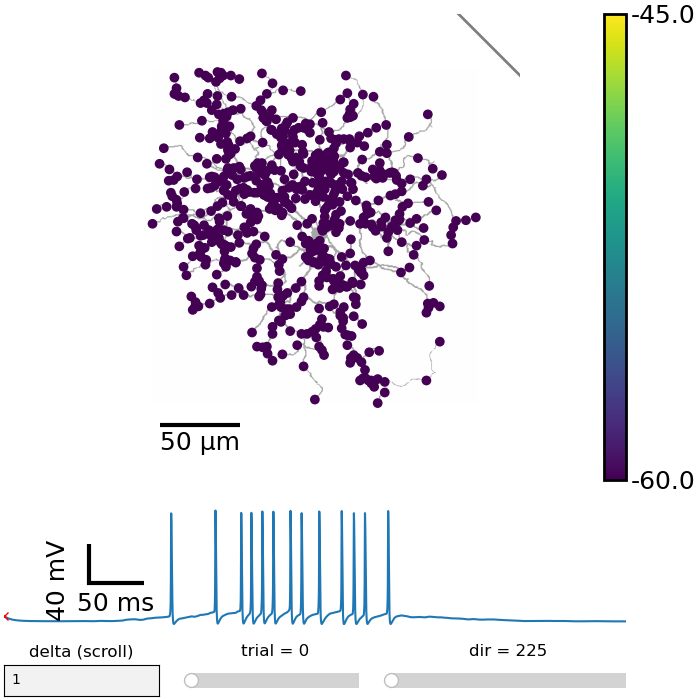

In [22]:
mr_scalebar_mode = True
if tuning is not None:
    rho = 0.0
    net = 3
    mr = MotionResponse(
        d[rho][net], 
        tree_k="Vm",
        figsize=(7, 7), 
        tree_vmin=-60,
        tree_vmax=-45,
        soma_vmin=-70,
        soma_vmax=50,
    )
    if mr_scalebar_mode:
        clean_axes(mr.soma_ax, remove_spines=["left", "right", "top", "bottom"])
        clean_axes(mr.tree_ax, remove_spines=["left", "right", "top", "bottom"])
        vm_sizex = 50
        vm_sizey = 40
        add_scalebar(
            mr.soma_ax,
            matchx=False, 
            matchy=False, 
            sizex=vm_sizex, 
            sizey=vm_sizey, 
            labelx="%i ms" % vm_sizex,
            labely="%i mV" % vm_sizey,
            sep=5,
            barwidth=3,
            loc="center",
            bbox_to_anchor=(100, 120),
            textprops={"fontsize": 18},
            ytextprops={"rotation": "vertical"},
        )
        tree_sizex = 50
        add_scalebar(
            mr.tree_ax,
            matchx=False, 
            matchy=False, 
            sizex=tree_sizex, 
            labelx="%i μm" % tree_sizex,
            sep=5,
            barwidth=3,
            loc="center",
            bbox_to_anchor=(200, 260),
            textprops={"fontsize": 18},
        )
    ticks = [mr.colorbar.vmin, mr.colorbar.vmax]
    mr.colorbar.set_ticks(ticks, labels=ticks, size=18)
    mr.colorbar_ax.tick_params(width=0, size=0)
    mr.colorbar.outline.set_linewidth(2)


In [23]:
if 0 and tuning is not None:
    name = "motion_%s_rho%s_net%i_tr%i_dir%i_%sms%s.svg" % (
        mr.tree_k,
        str(rho).replace(".", "p"),
        net,
        mr.trial_idx,
        mr.dirs[mr.dir_idx],
        str(round(mr.time[mr.tree_t * mr.rate_diff], 2)).replace(".", "p"),
        "_sbmode" if mr_scalebar_mode else "",
    )
    mr.fig.savefig(os.path.join(fig_path, name))

In [24]:
if 0 and tuning is not None:
    tree_dt = 0.2 # ms
    sample_start = int(135 / tree_dt)
    sample_end = int(345 / tree_dt)
    sample_inter = 3
    # gif_inter = sample_inter * 2
    gif_inter = 1
    dpi = 100
    tree_ts = np.arange(sample_start, sample_end, sample_inter)
    
    def update(t):
        mr.tree_t = t
        soma_t = mr.tree_t * mr.rate_diff
        mr.scat.set_array(mr.tree[mr.trial_idx, mr.dir_idx, :, mr.tree_t])
        mr.line.set_ydata(mr.soma[mr.trial_idx, mr.dir_idx])
        mr.t_mark.set_data(
            mr.time[soma_t], mr.soma[mr.trial_idx, mr.dir_idx, soma_t]
        )
        mr.stim.set_xy(mr.sweeps[mr.dir_idx][soma_t])
        return [mr.stim, mr.scat, mr.t_mark, mr.line]
    
    anim = FuncAnimation(
        mr.fig,
        update,
        frames=tree_ts,
        interval=gif_inter,
    )
    name = "motion_%s_rho%s_net%i_tr%i_dir%i%s.gif" % (
        mr.tree_k,
        str(rho).replace(".", "p"),
        net,
        mr.trial_idx,
        mr.dirs[mr.dir_idx],
        "_sbmode" if mr_scalebar_mode else "",
    )
    anim.save(os.path.join(fig_path, name), dpi=dpi, writer="imagemagick")
    plt.close(mr.fig)

In [25]:
close_button()

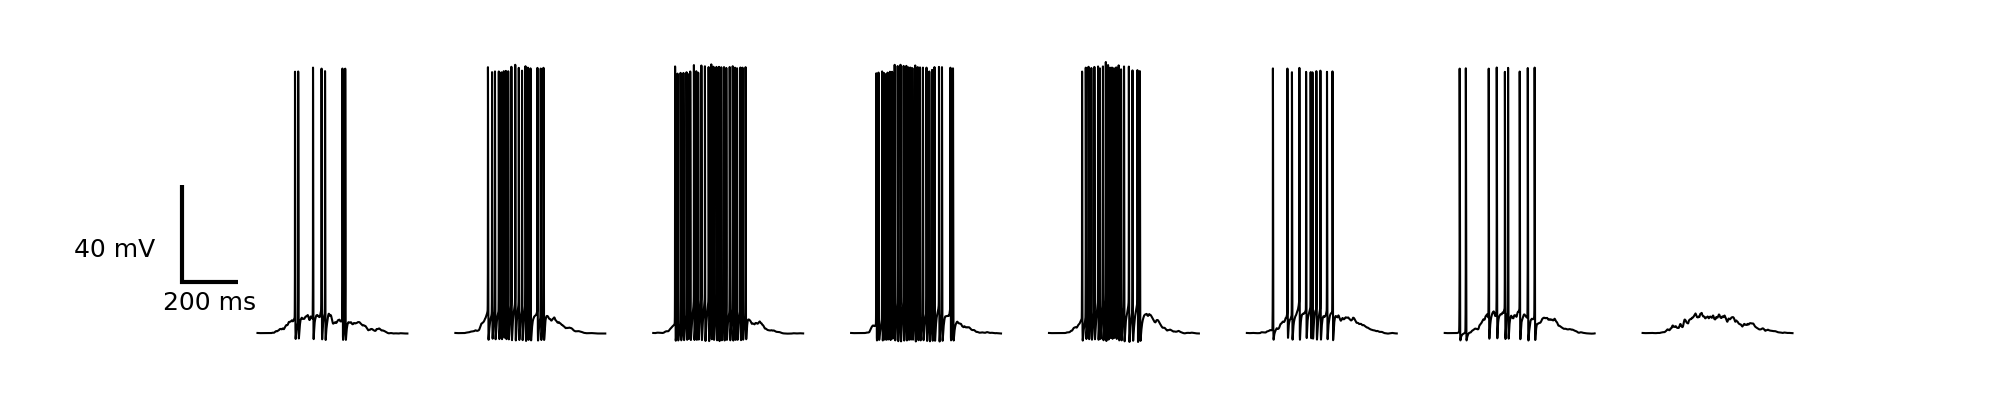

In [41]:
rho = 1.0
net = 0
trial = 2
incl_arrows = False

vm_pts = d[rho][net]["soma"]["Vm"].shape[-1]
vm_xaxis = np.linspace(0, vm_pts * d[rho][net]["params"]["dt"], vm_pts)

trial_vm_fig, trial_vm_ax = plt.subplots(1, len(dir_labels), sharex=True, sharey=True, figsize=(20, 4))
for i in range(len(dir_labels)):
    trial_vm_ax[i].plot(vm_xaxis[300:], d[rho][net]["soma"]["Vm"][trial, i, 300:], c="black")
    trial_vm_ax[i].patch.set_alpha(0)
    if incl_arrows: trial_vm_ax[i].set_title(arrow_lbls[i], fontsize=16)

clean_axes(trial_vm_ax, remove_spines=["left", "right", "top", "bottom"])

sizex = 200
sizey = 40
add_scalebar(
    trial_vm_ax[0], 
    matchx=False, 
    matchy=False, 
    sizex=sizex, 
    sizey=sizey, 
    labelx="%i ms" % sizex,
    labely="%i mV" % sizey,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(165, 150),
    textprops={"fontsize": 18},
)

name = os.path.join(fig_path, "vm_rho%s_net%i_trial%i" % (("%.2f" % rho).replace(".", "p"), net, trial))
for ext in [".png", ".svg"]:
    trial_vm_fig.savefig(name + ext)

In [27]:
# cai_ds_fig = plot_tree_tuning(tuning_cai, 1)

In [28]:
# vm_ds_fig = plot_tree_tuning(tuning_vm, 3)

In [29]:
if "rng_state" in d[0.0][0]["params"]:
    d[1.0][1]["params"]["rng_state"][0]

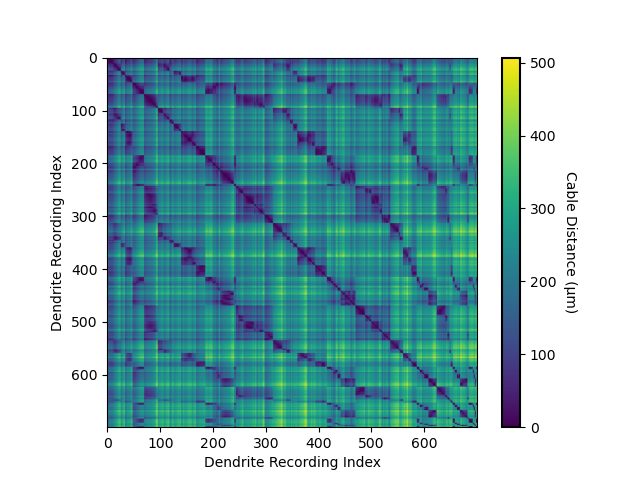

In [30]:
rec_dists = d[0.0][0]["dendrites"]["rec_dists"][:]
rec_dist_fig, rec_dist_ax = plt.subplots(1)
rec_dist_im = rec_dist_ax.imshow(rec_dists)
rec_dist_ax.set_xlabel("Dendrite Recording Index")
rec_dist_ax.set_ylabel("Dendrite Recording Index")
rec_dist_cbar = rec_dist_fig.colorbar(rec_dist_im)
rec_dist_cbar.set_label("Cable Distance (μm)", rotation=270, labelpad=15)
rec_dist_cbar.outline.set_linewidth(1.5)

In [31]:
rho = 0.0
net = 3
wonk_theta = 110
wonk_dsi = 0.1
wonk_dist = 10

wonk_tuning = tuning_cai[rho][net]["avg"]
wonk = np.where((np.abs(wonk_tuning["theta"]) > wonk_theta) * (wonk_tuning["DSi"] > wonk_dsi))[1]
print("wonky tuning sites (%s° wrong, DSI > %s):" % (str(wonk_theta), str(wonk_dsi)))
print(wonk)

culprit_sites = []
for w in wonk:
    culprit_sites.append(np.where(rec_dists[w] < wonk_dist)[0])
# if not any(map(lambda a: len(a) > 0, culprit_sites)):
#     raise ValueError("No culprit recording sites (within %sμm of wonky sites), increase wonk_dist" % wonk_dist)
culprit_sites = np.unique(np.concatenate(culprit_sites) if any(map(lambda a: len(a) > 0, culprit_sites)) else [])
print("\nexpanded culprit recording sites (within %sμm of wonky sites):" % wonk_dist)
print(culprit_sites)

culprit_syns = []
for s in culprit_sites:
    if s in syn_rec_lookups["to_syn"]:
        culprit_syns.append(syn_rec_lookups["to_syn"][s])
culprit_syns = np.sort(np.array(culprit_syns))
print("\nculprit synapses (colocated with culprit recording sites):")
print(culprit_syns)

if len(culprit_syns) > 0:
    culprit_syn_locs = d[rho][net]["syn_locs"][culprit_syns]
    culprit_bp_locs = {k: d[rho][net]["sac_net"]["wiring"]["bp_locs"][k][culprit_syns] for k in ["E", "I"]}
    culprit_bp_probs = {k: d[rho][net]["sac_net"]["wiring"]["probs"][k][culprit_syns] for k in ["E", "I"]}
else:
    culprit_syn_locs = np.zeros((2, 0))
    culprit_bp_locs = {k: np.zeros((2, 0)) for k in ["E", "I"]}
    culprit_bp_probs = {k: np.zeros((0)) for k in ["E", "I"]}

wonky tuning sites (110° wrong, DSI > 0.1):
[616 617 618 619 620 621 668 669 670 671]

expanded culprit recording sites (within 10μm of wonky sites):
[616 617 618 619 620 621 668 669 670 671]

culprit synapses (colocated with culprit recording sites):
[303 318 319 327 328]


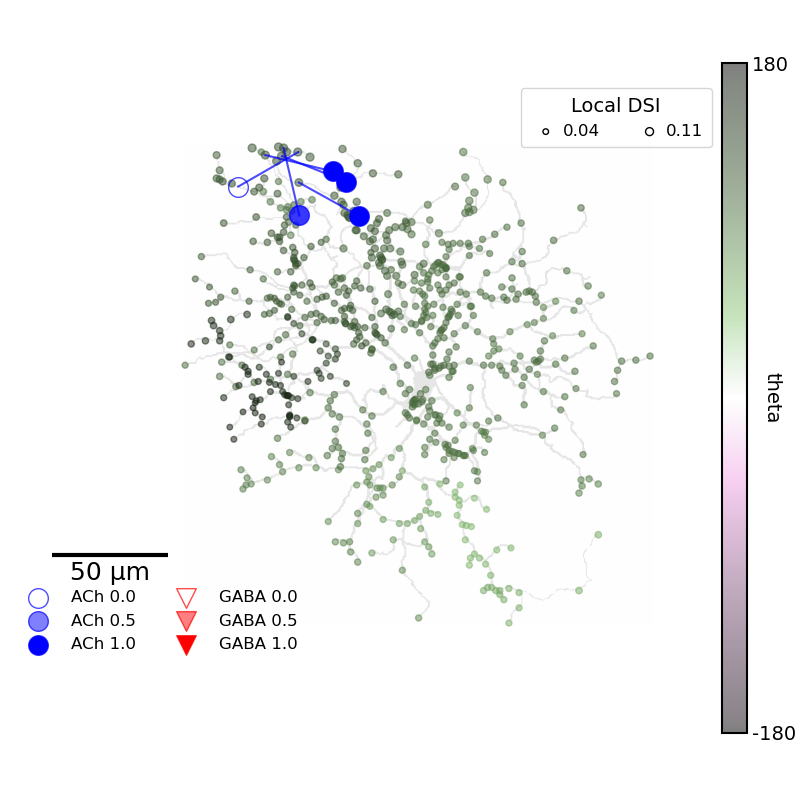

In [32]:
show_tuning = True
show_dsgc = True
show_sacs = True
dsgc_alpha = 0.1

if not show_tuning and not show_dsgc and not show_sacs:
    raise ValueError("Nothing to see here...")
    
tuning_culprit_fig, tuning_culprit_ax = plt.subplots(
    1, 2, figsize=(8, 8), gridspec_kw={"width_ratios": [0.96, 0.04]})
tuning_culprit_ax[0].set_aspect("equal")

if show_dsgc:
    dsgc_img, extent = get_dsgc_img()
    tuning_culprit_ax[0].imshow(dsgc_img, extent=extent, alpha=dsgc_alpha, cmap="gray")

if show_tuning:
    tuning_scatter, tuning_cbar = tree_tuning(
        tuning_culprit_fig,
        tuning_culprit_ax[0],
        rec_locs,
        wonk_tuning["theta"],
        wonk_tuning["DSi"],
        abstheta=False,
        theta_min=-180,
        theta_max=180,
        dsi_mul=250,
        min_dsi_size=5,
        # cmap=angle_cmap(use_hpl=True),
        cmap=angle_cmap(pos_hue=bmb_magenta_hsl[0], neg_hue=bmb_green_hsl[0], use_hpl=True),
        cbar=True,
        cbar_kwargs={"cax": tuning_culprit_ax[-1]},
        # legend_kwargs={"loc": "upper right"},
        legend_kwargs={
            "loc": "upper right", "bbox_to_anchor": (0.7, 0.7, 0.2, 0.2), "frameon": True,
            "borderpad": 0.5, "handletextpad": 0, "title": "Local DSI", "title_fontsize": 14,
        },
    )
    ticks = [int(tuning_cbar.vmin), int(tuning_cbar.vmax)]
    tuning_cbar.set_ticks(ticks, labels=ticks, size=14)
    tuning_cbar.set_label("theta", rotation=270, labelpad=-10, fontsize=14)
    tuning_culprit_ax[-1].tick_params(width=0, size=0)
    tuning_cbar.outline.set_linewidth(1.5)
else:
    tuning_culprit_ax[-1].remove()

if show_sacs:
    ana.plot_dends_overlay(
        tuning_culprit_fig,
        tuning_culprit_ax[0],
        culprit_syn_locs,
        culprit_bp_locs,
        culprit_bp_probs,
        dir_labels,
        stim_angle=stim_angle,
        dsgc_alpha=0.0,
        sac_thickness=1.5,
        sac_marker_size=200,
        sac_min_marker_size=min_size,
        syn_choice_seed=seed,
        show_plex=show_plex,
        ach_color="blue",
        gaba_color="red",
        ach_edge="blue",
        gaba_edge="red",
        cmap=cmap,
        ach_cmap=ach_cmap,
        gaba_cmap=gaba_cmap,
        incl_cbars=False,
    )

# tuning_culprit_ax[0].set_xlim(-10, 230)
# tuning_culprit_ax[0].set_ylim(-10, 230)

tree_sizex = 50
add_scalebar(
    tuning_culprit_ax[0],
    matchx=False, 
    matchy=False, 
    sizex=tree_sizex, 
    labelx="%i μm" % tree_sizex,
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(110, 230),
    textprops={"fontsize": 18},
)

tuning_culprit_fig.set_layout_engine("compressed")

tuning_lbl = "tuning_" if show_tuning else ""
sacs_lbl = "culprits_"
dsgc_lbl = "over_dsgc_" if show_dsgc else ""
name = os.path.join(fig_path, "%s%s%srho%s_net%i_wonk_%s°_dsi%s_dist%s" % (
        tuning_lbl, sacs_lbl, dsgc_lbl, str(rho), net, str(wonk_theta), str(wonk_dsi), str(wonk_dist)))
for ext in [".png", ".svg"]:
    tuning_culprit_fig.savefig(name + ext, bbox_inches="tight")

In [33]:
if not ttx:
    def track_spikes(soma, dends, diff_win=5, peak_win=20):
        def diff_area(child, parent, t0, t1):
            return np.sum(dends[child, t0:t1] - dends[parent, t0:t1])

        def aux(parent, pmax):
            if parent < 0:
                prec = soma
                pnode = 0
            else:
                prec = dends[parent]
                pnode = (parent - (parent % 2)) // 2 + 1
            ds = [n - 1 for n in dsgc_graph.neighbors(pnode)]  # dend idxs (shifted to 0-index, adjusted for soma)
            if len(ds) > 0:
                rs = [dend * 2 + 1 for dend in ds]  # pos 1.0 recording idxs for each dend
                scores = [diff_area(r, parent, pmax - diff_win, pmax) for r in rs]
                if np.max(scores) < 0:
                    # shift over and check again (maybe child is too early so neg phase dominated the window)
                    scores = [diff_area(r, parent, pmax - diff_win * 2, pmax - diff_win) for r in rs]
                if np.max(scores) < 0 and parent >= 0:
                    # if shifted scores are still negative, the spike did not originate in the children
                    # not sure if forced step from soma (parent >= 0) is still necessary with shifted scores
                    return parent
                else:
                    parent = rs[np.argmax(scores)]
                    pmax = pmax + np.argmax(dends[parent, pmax-peak_win:pmax]) - peak_win
                    return aux(parent, pmax)
            else:
                return parent

        spk_idxs, _ = signal.find_peaks(soma, height=20)
        origins = [aux(-1, spk) for spk in spk_idxs]
        return origins

    origins = {rho: {} for rho in rhos}
    origins_sum = {rho: np.zeros((len(idxs), n_trials, n_dirs, rec_dists.shape[0])) for rho in rhos} 
    path_sum = {rho: np.zeros((len(idxs), n_trials, n_dirs, len(dsgc_graph))) for rho in rhos} 
    for rho in rhos:
        for net in idxs:
            origins[rho][net] = []
            for tr in range(n_trials):
                tr_orgs = []
                for i in range(n_dirs):
                    tr_orgs.append(track_spikes(
                        d[rho][net]["soma"]["Vm"][tr, i],
                        d[rho][net]["dendrites"]["Vm"][tr, i, :],
                    ))
                    for org in tr_orgs[-1]:
                        origins_sum[rho][net, tr, i, org] += 1
                        node_idx = (org - 1) // 2 + 1  # convert from rec idx (pos 1.0, shifted for 0th soma)
                        for n in nx.shortest_path(dsgc_graph, source=0, target=node_idx): 
                            path_sum[rho][net, tr, i, n] += 1
                origins[rho][net].append(tr_orgs)
    avg_path_sum = {rho: np.mean(path_sum[rho], axis=1) for rho in rhos}
    net_avg_path_sum = {rho: np.mean(avg_path_sum[rho], axis=0) for rho in rhos}

    if 0:
        rho = 0.0
        net = 3  
        trial = 2
        i = 7 
        for org in origins[rho][net][trial][i]:
            print("rec %i at (%.2f, %.2f)" % (org, *rec_locs[org]))

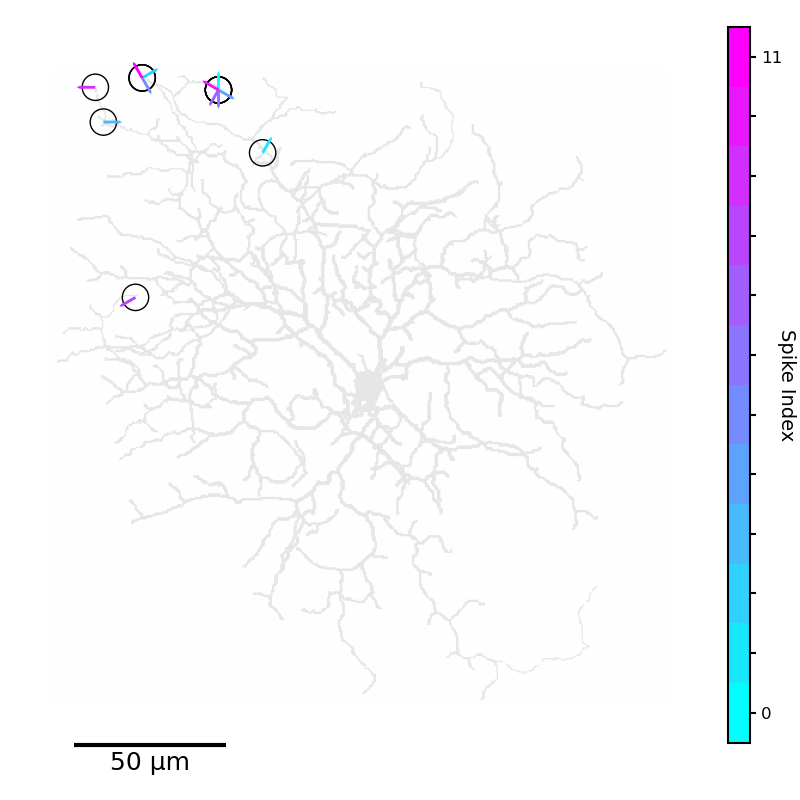

In [34]:
if not ttx:
    rho = 0.0
    net = 3  
    trial = 2
    i = 7 
    origs = origins[rho][net][trial][i]

    arrow_mode = True
    annotate_mode = False
    arrow_sz = 180
    spk_ownership = {r: [] for r in origs}
    ring_lvl = []
    origs_mass = np.zeros(2)
    for i, org in enumerate(origs):
        ring_lvl.append(len(spk_ownership[org]))
        spk_ownership[org].append(i)
        origs_mass += rec_locs[org]
    origs_mass /= len(origs)

    ring_base = 10
    ring_step = 40
    ring_lw = 2
    cmap = plt.get_cmap("cool", lut=len(origs))
    # cmap = plt.get_cmap("jet", lut=len(origs))

    spk_origins_fig, spk_origins_ax = plt.subplots(
        1, 2, figsize=(8, 8), gridspec_kw={"width_ratios": [0.97, 0.03]})
    dsgc_img, dsgc_extent = get_dsgc_img()
    spk_origins_ax[0].imshow(dsgc_img, extent=dsgc_extent, alpha=dsgc_alpha, cmap="gray")
    texts = []
    if arrow_mode:
        rads = np.arange(len(origs)) * -np.pi * 2 / len(origs) + (np.pi / 2)  # 0 at 12oclock, clockwise
        u = np.cos(rads) * np.sqrt(arrow_sz) / 72  # scaling into points to match markersize units
        v = np.sin(rads) * np.sqrt(arrow_sz) / 72
        xy = np.stack([rec_locs[org] for org in origs], axis=1)
        c = np.arange(len(origs)) / (len(origs) - 1)
        spk_origins_ax[0].scatter(xy[0], xy[1], s=arrow_sz * 2, facecolors="none", edgecolors="black")
        spk_origins_ax[0].quiver(
            xy[0], xy[1], u, v, c, angles='xy', scale_units='inches', scale=1, width=0.004, headwidth=1, headlength=1, cmap=cmap)
    else:
        for i, org in enumerate(origs):
            s = ring_base + (ring_lvl[i] + 1)**2 * ring_step
            spk_origins_ax[0].scatter(*rec_locs[org], s=s, facecolors="none", edgecolors=cmap(i / (len(origs) - 1)))

    if annotate_mode:
        # TODO: try offsetting text away along the vectors between the centre of mass of origins and each origin
        for org, spk_order in spk_ownership.items():
            # texts.append(spk_origins_ax.text(*rec_locs[org], ", ".join(map(str, spk_order)), fontsize=14))
            spk_origins_ax[0].annotate(
                ", ".join(map(str, spk_order)),
                rec_locs[org],
                xytext=(-20, 10),
                textcoords="offset points", 
                fontsize=14,
                arrowprops=dict(arrowstyle="->", relpos=(0.5, 0.5), shrinkA=0, shrinkB=0),
            )

    cbar_lw = 1.5
    origins_cbar = spk_origins_fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap),
        orientation="vertical",
        cax=spk_origins_ax[1],
        values=np.arange(len(origs)),
        ticks=np.arange(len(origs)),
    )
    origins_cbar.set_label("Spike Index", rotation=270, labelpad=10, fontsize=14)
    spk_origins_ax[-1].tick_params(width=cbar_lw, size=4)
    origins_cbar.outline.set_linewidth(cbar_lw)
    spk_origins_ax[1].set_yticklabels(
        [0] + [None for _ in range(len(origs) - 2)] + [len(origs) - 1], fontsize=12)
    spk_origins_ax[0].set_aspect("equal")
    spk_origins_ax[0].set_xlim(-15, 220)
    spk_origins_ax[0].set_ylim(5, 240)

    tree_sizex = 50
    add_scalebar(
        spk_origins_ax[0],
        matchx=False, 
        matchy=False, 
        sizex=tree_sizex, 
        labelx="%i μm" % tree_sizex,
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(150, 40),
        textprops={"fontsize": 18},
    )

    spk_origins_fig.set_layout_engine("compressed")

    name = os.path.join(fig_path, "spike_origins_rho%s_net%i_trial%i" % (("%.2f" % rho).replace(".", "p"), net, trial))
    for ext in exts:
        spk_origins_fig.savefig(name + ext, bbox_inches="tight")

In [35]:
with h5.File("thesis_morphology.h5", "r") as f:
    morph = unpack_hdf(f)

print("morph keys:", list(morph.keys()))

morph keys: ['soma3d', 'soma2d', 'dend_diam', 'dend3d']


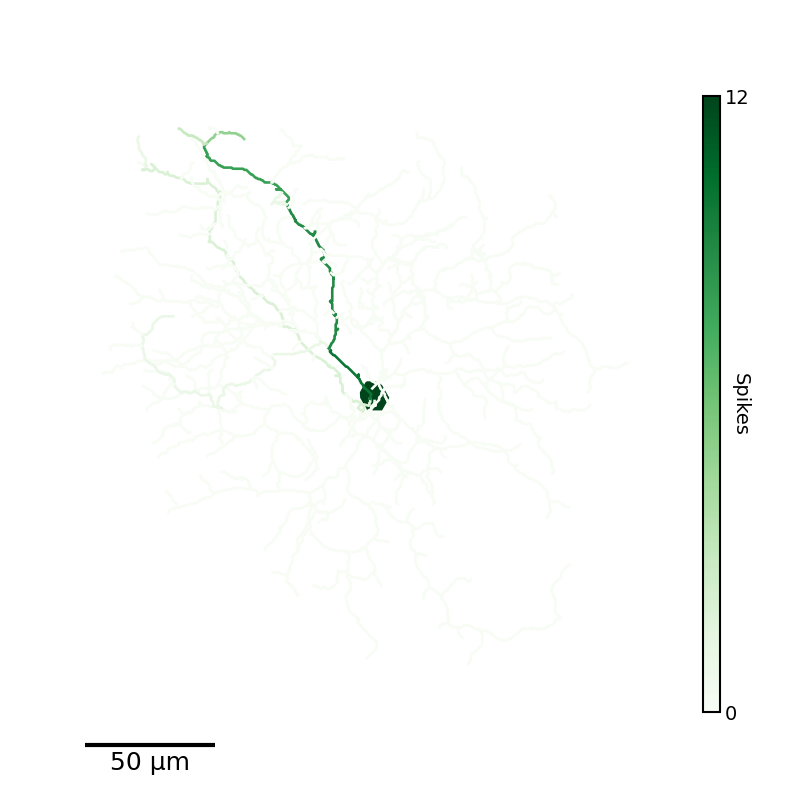

In [36]:
if not ttx:
    rho = 0.0
    net = 3  
    # net = None
    trial = 2
    # trial = None
    i = 7 

    diam_mode = "fixed"  # "lw" | "3d" | "model" | "fixed"
    dend_lw = 1.0        # used for "lw" diam_mode (regular ax.plot, axis units)
    fixed_diam = 1.0     # used for "fixed" diam_mode (data unit lw)
    alpha =  1
    cmap = plt.get_cmap("cool")
    cmap = plt.get_cmap("Blues")
    cmap = plt.get_cmap("PuRd")
    cmap = plt.get_cmap("Reds")
    cmap = plt.get_cmap("Greens")
    bgc = None

    path_val = net_avg_path_sum[rho] if net is None else (
        avg_path_sum[rho][net] if trial is None else path_sum[rho][net, trial, :])
    spk_vmax = path_val[i, 0]
    dsgc_paths_fig, dsgc_paths_ax = plt.subplots(
        1, 2, figsize=(8, 8), gridspec_kw={"width_ratios": [0.97, 0.03]})

    c = cmap(path_val[i, 0] / spk_vmax)
    dsgc_paths_ax[0].fill(morph["soma2d"][:, 0], morph["soma2d"][:, 1], c=c, alpha=alpha)
    dend_lines = []
    for n in range(len(morph["dend3d"])):
        pts = morph["dend3d"][n]
        c = cmap(path_val[i, n + 1] / spk_vmax)
        if diam_mode == "lw":
            dsgc_paths_ax[0].plot(pts[:, 0], pts[:, 1], lw=dend_lw, c=c, alpha=alpha)
        else:
            lw = fixed_diam if diam_mode == "fixed" else (pts[0, 3] if diam_mode == "3d" else morph["dend_diam"][n])
            dend_lines.append(LineDataUnits(pts[:, 0], pts[:, 1], c=c, alpha=alpha, linewidth=lw))
            dsgc_paths_ax[0].add_line(dend_lines[-1])

    dsgc_paths_ax[0].set_xlim(0, 210)
    dsgc_paths_ax[0].set_ylim(10, 225)
    dsgc_paths_ax[0].set_aspect("equal")

    dsgc_paths_cbar = dsgc_paths_fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=spk_vmax), cmap=cmap),
        orientation="vertical",
        cax=dsgc_paths_ax[1],
    )
    ticks = [int(dsgc_paths_cbar.vmin), int(dsgc_paths_cbar.vmax)]
    dsgc_paths_cbar.set_ticks(ticks, labels=ticks, size=14)
    dsgc_paths_cbar.set_label("Spikes", rotation=270, labelpad=0, fontsize=14)
    dsgc_paths_ax[-1].tick_params(width=0, size=0)
    dsgc_paths_cbar.outline.set_linewidth(1.5)

    tree_sizex = 50
    add_scalebar(
        dsgc_paths_ax[0],
        matchx=False, 
        matchy=False, 
        sizex=tree_sizex, 
        labelx="%i μm" % tree_sizex,
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(150, 40),
        textprops={"fontsize": 18},
    )

    net_lbl = "AVG" if net is None else str(net)
    trial_lbl = "AVG" if trial is None else str(trial)
    name = os.path.join(
        fig_path, "dsgc_spike_paths_rho%s_net%s_trial%s" % (("%.2f" % rho).replace(".", "p"), net_lbl, trial_lbl))
    for ext in exts:
        dsgc_paths_fig.savefig(name + ext, bbox_inches="tight")

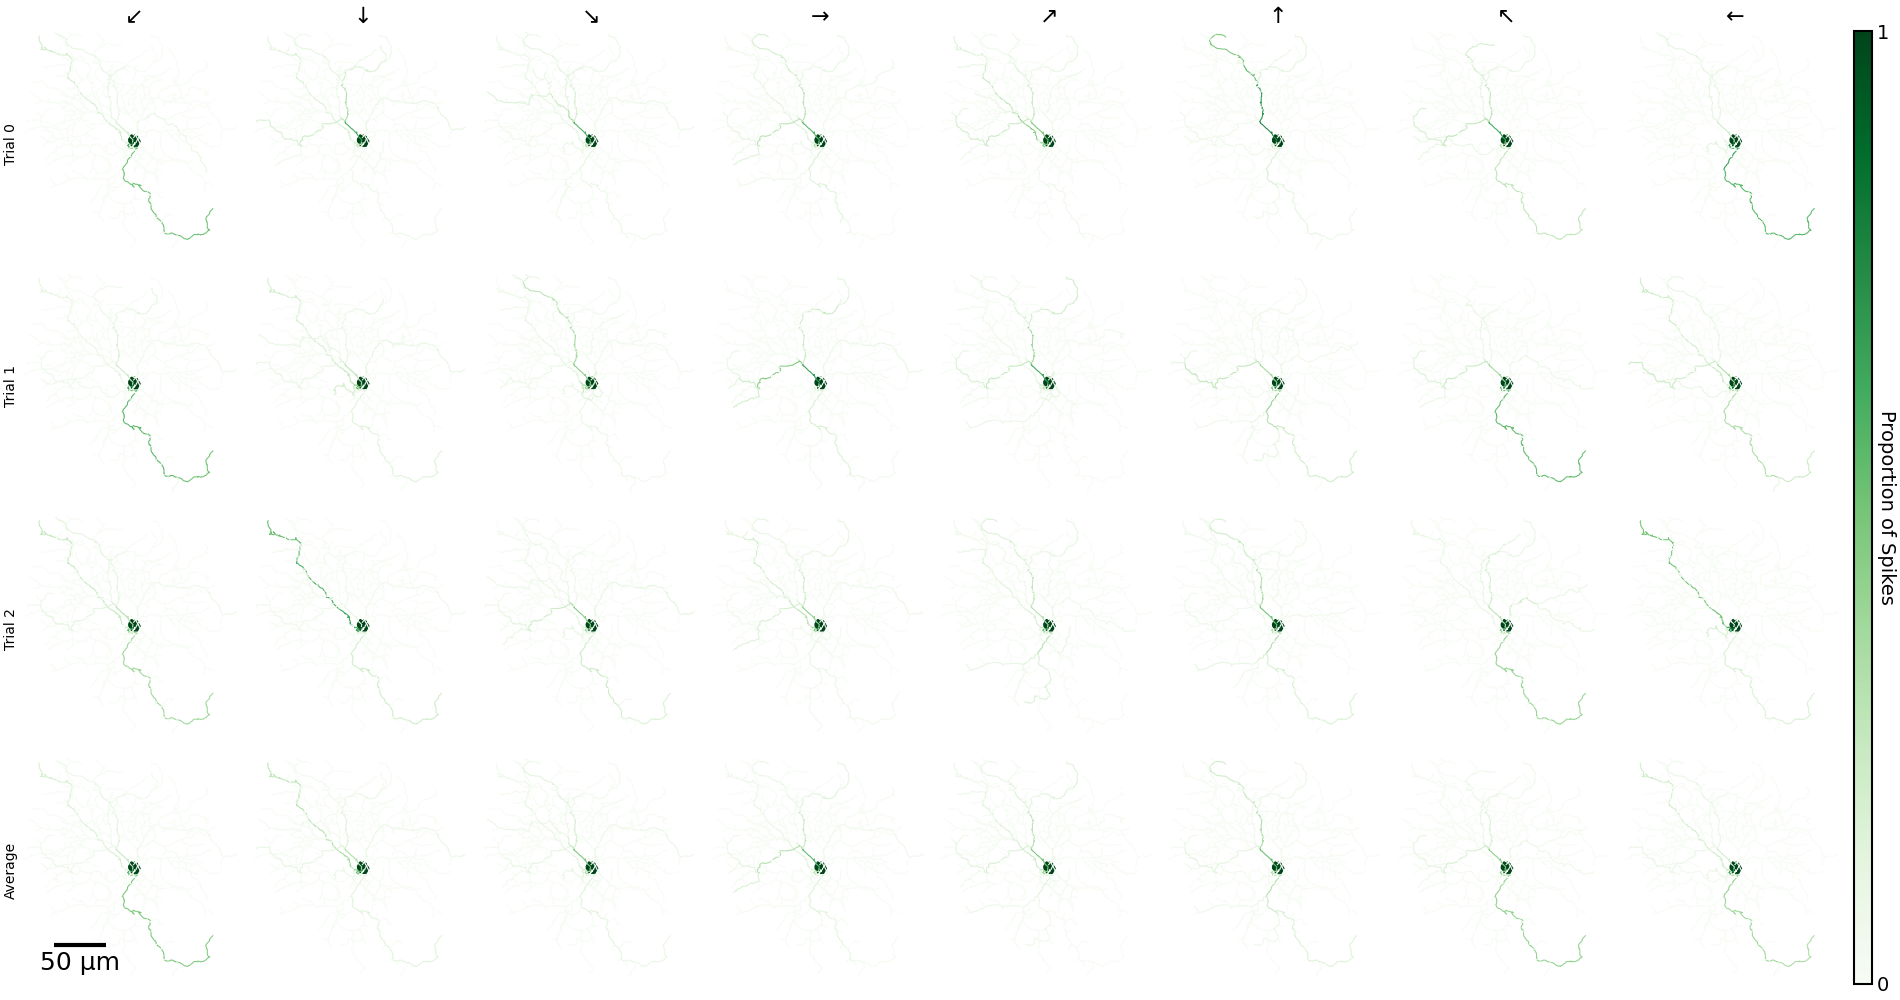

In [37]:
if not ttx:
    rho = 0.0
    net = 2  
    trials = np.arange(n_trials)
    # trials = [0]
    # trials = []
    incl_avg = True or not len(trials) 

    label_singles = False
    no_labels = False

    diam_mode = "fixed"  # "lw" | "3d" | "model" | "fixed"
    dend_lw = 1.0        # used for "lw" diam_mode (regular ax.plot, axis units)
    fixed_diam = 1.0     # used for "fixed" diam_mode (data unit lw)
    alpha =  1
    cmap = plt.get_cmap("cool")
    cmap = plt.get_cmap("Blues")
    cmap = plt.get_cmap("PuRd")
    cmap = plt.get_cmap("Reds")
    cmap = plt.get_cmap("Greens")
    bgc = None

    row_height = 10 / 4
    nrows = len(trials) + int(incl_avg)
    dsgc_paths_grid_fig = plt.figure(figsize=(19, row_height * nrows))
    gs = dsgc_paths_grid_fig.add_gridspec(
        nrows=nrows,
        ncols=n_dirs+1,
        width_ratios=[0.99 / n_dirs] * n_dirs + [0.01],
    )
    for tr in range(len(trials) + int(incl_avg)):
        path_val = avg_path_sum[rho][net] if tr == len(trials) else path_sum[rho][net, trials[tr], :]
        for i in range(n_dirs):
            spk_vmax = path_val[i, 0]
            c = cmap(path_val[i, 0] / spk_vmax if spk_vmax else 0)
            ax = dsgc_paths_grid_fig.add_subplot(gs[tr, i])
            ax.fill(morph["soma2d"][:, 0], morph["soma2d"][:, 1], c=c, alpha=alpha)
            ax.set_xlim(0, 210)
            ax.set_ylim(10, 225)
            ax.set_aspect("equal")
            clean_axes(ax, remove_spines=["top", "left", "bottom", "right"])
            for n in range(len(morph["dend3d"])):
                pts = morph["dend3d"][n]
                c = cmap(path_val[i, n + 1] / spk_vmax if spk_vmax else 0)
                if diam_mode == "lw":
                    ax.plot(pts[:, 0], pts[:, 1], lw=dend_lw, c=c, alpha=alpha)
                else:
                    lw = fixed_diam if diam_mode == "fixed" else (pts[0, 3] if diam_mode == "3d" else morph["dend_diam"][n])
                    ax.add_line(LineDataUnits(pts[:, 0], pts[:, 1], c=c, alpha=alpha, linewidth=lw))
            if i == 0:
                if tr == len(trials):
                    tree_sizex = 50
                    add_scalebar(
                        ax,
                        matchx=False, 
                        matchy=False, 
                        sizex=tree_sizex, 
                        labelx="%i μm" % tree_sizex,
                        sep=5,
                        barwidth=3,
                        loc="center",
                        bbox_to_anchor=(80, 40),
                        textprops={"fontsize": 18},
                        hidey=False,
                    )
                if (nrows > 1 or label_singles) and not no_labels:
                    ax.set_ylabel(("Trial %i" % trials[tr]) if tr < len(trials) else "Average")
            if tr == 0:
                ax.set_title(arrow_lbls[i], fontsize=16)


    dsgc_paths_grid_fig.set_layout_engine("compressed")

    dsgc_paths_grid_cbar_ax = dsgc_paths_grid_fig.add_subplot(gs[:, -1])
    dsgc_paths_grid_cbar = dsgc_paths_grid_fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1), cmap=cmap),
        orientation="vertical",
        cax=dsgc_paths_grid_cbar_ax,
    )
    ticks = [int(dsgc_paths_grid_cbar.vmin), int(dsgc_paths_grid_cbar.vmax)]
    dsgc_paths_grid_cbar.set_ticks(ticks, labels=ticks, size=14)
    dsgc_paths_grid_cbar.set_label("Proportion of Spikes", rotation=270, labelpad=5, fontsize=14)
    dsgc_paths_grid_cbar_ax.tick_params(width=0, size=0)
    dsgc_paths_grid_cbar.outline.set_linewidth(1.5)

    trial_lbl = "_trials%s" % "-".join(map(str, trials)) if 0 < len(trials) < n_trials else ""
    avg_lbl = "_only_avg" if not len(trials) else "_with_avg" if incl_avg else "" 
    name = os.path.join(
        fig_path, "dsgc_spike_paths_grid_rho%s_net%i%s%s" % (("%.2f" % rho).replace(".", "p"), net, trial_lbl, avg_lbl))
    for ext in exts:
        dsgc_paths_grid_fig.savefig(name + ext, bbox_inches="tight")

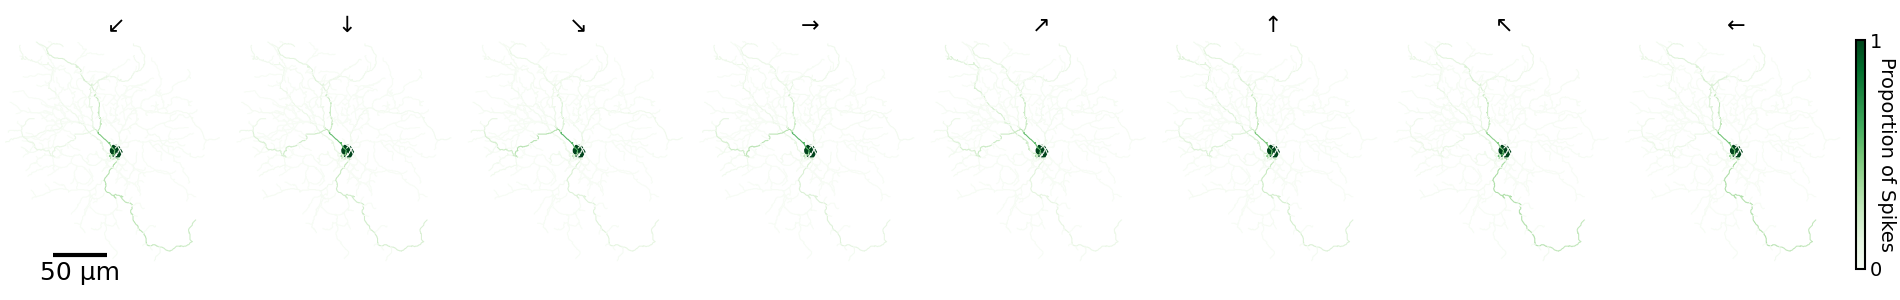

In [38]:
if not ttx:
    rho = 0.0

    diam_mode = "fixed"  # "lw" | "3d" | "model" | "fixed"
    dend_lw = 1.0        # used for "lw" diam_mode (regular ax.plot, axis units)
    fixed_diam = 1.0     # used for "fixed" diam_mode (data unit lw)
    alpha =  1
    cmap = plt.get_cmap("cool")
    cmap = plt.get_cmap("Blues")
    cmap = plt.get_cmap("PuRd")
    cmap = plt.get_cmap("Reds")
    cmap = plt.get_cmap("Greens")
    bgc = None

    dsgc_paths_net_avg_fig, dsgc_paths_net_avg_ax = plt.subplots(
        1,
        n_dirs + 1,
        figsize=(19, 3),
        gridspec_kw={"width_ratios": [0.995 / n_dirs] * n_dirs + [0.005]}
    )
    for i in range(n_dirs):
        spk_vmax = net_avg_path_sum[rho][i, 0]
        c = cmap(net_avg_path_sum[rho][i, 0] / spk_vmax if spk_vmax else 0)
        ax = dsgc_paths_net_avg_ax[i]
        ax.fill(morph["soma2d"][:, 0], morph["soma2d"][:, 1], c=c, alpha=alpha)
        ax.set_xlim(0, 210)
        ax.set_ylim(10, 225)
        ax.set_aspect("equal")
        clean_axes(ax, remove_spines=["top", "left", "bottom", "right"])
        ax.set_title(arrow_lbls[i], fontsize=16)
        for n in range(len(morph["dend3d"])):
            pts = morph["dend3d"][n]
            c = cmap(net_avg_path_sum[rho][i, n + 1] / spk_vmax)
            if diam_mode == "lw":
                ax.plot(pts[:, 0], pts[:, 1], lw=dend_lw, c=c, alpha=alpha)
            else:
                lw = fixed_diam if diam_mode == "fixed" else (pts[0, 3] if diam_mode == "3d" else morph["dend_diam"][n])
                ax.add_line(LineDataUnits(pts[:, 0], pts[:, 1], c=c, alpha=alpha, linewidth=lw))

    dsgc_paths_net_avg_cbar = dsgc_paths_net_avg_fig.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1), cmap=cmap),
        orientation="vertical",
        cax=dsgc_paths_net_avg_ax[-1],
    )
    ticks = [int(dsgc_paths_net_avg_cbar.vmin), int(dsgc_paths_net_avg_cbar.vmax)]
    dsgc_paths_net_avg_cbar.set_ticks(ticks, labels=ticks, size=14)
    dsgc_paths_net_avg_cbar.set_label("Proportion of Spikes", rotation=270, labelpad=10, fontsize=14)
    dsgc_paths_net_avg_ax[-1].tick_params(width=0, size=0)
    dsgc_paths_net_avg_cbar.outline.set_linewidth(1.5)

    tree_sizex = 50
    add_scalebar(
        dsgc_paths_net_avg_ax[0],
        matchx=False, 
        matchy=False, 
        sizex=tree_sizex, 
        labelx="%i μm" % tree_sizex,
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(80, 30),
        textprops={"fontsize": 18},
    )

    dsgc_paths_net_avg_fig.set_layout_engine("compressed")

    name = os.path.join(
        fig_path, "dsgc_spike_paths_rho%s_netAVG" % (("%.2f" % rho).replace(".", "p")))
    for ext in exts:
        dsgc_paths_net_avg_fig.savefig(name + ext, bbox_inches="tight")

In [39]:
analysis_dict = {
    "ttx": ttx,
    "rhos": rhos,
    "dir_labels": dir_labels,
    "xaxis": xaxis,
    "sac_thetas": sac_thetas,
    "sac_deltas": sac_deltas,
    "metrics": metrics,
    "tuning_vm": tuning_vm,
    "tuning_cai": tuning_cai,
}
if not ttx:
    # convert ragged list into int->ndarry dicts to fit in to hdf (no objects). Must unpack on other side. 
    analysis_dict["origins"] = map_data(lambda ragged: {
        tr: {dr: np.array(ragged[tr][dr]) for dr in range(len(ragged[tr]))} 
        for tr in range(len(ragged))
    }, origins)
    analysis_dict["origins_sum"] = origins_sum
    analysis_dict["path_sum"] = path_sum
    analysis_dict["avg_path_sum"] = avg_path_sum
    analysis_dict["net_avg_path_sum"] = net_avg_path_sum
pack_hdf(os.path.join(analysis_path, load_name), analysis_dict)